In [18]:
import sys
import os
sys.path.append(os.path.abspath("../../"))

import numpy as np
import pandas as pd
import ast
import utils
from collections import defaultdict
# Color clustering
from sklearn.cluster import KMeans
# Cluster naming
from scipy.spatial import KDTree
from matplotlib import colors as mcolors
# Cluster plotting
import plot_automations as plotter

In [19]:
df = pd.read_csv("../../00_preprocessing/omniart-paintings-filtered-clean-hsb.csv.gz")

In [20]:
df

,artwork_name,artist_full_name,creation_year,century,school,color_pallete,dominant_color,palette_count,decade,H,S,B
0,70 amx,xynphix,2007.0,21.0,modern,"['#e2f5e5', '#a5ab9e', '#65c7a3', '#243b39', '...",#a5ab9e,"[4009, 7637, 3303, 6147, 4742, 3908, 7216, 514...",2000,"[0.3596491228070177, 0.2435897435897434, 0.438...","[0.07755102040816333, 0.0760233918128654, 0.49...","[0.9607843137254902, 0.6705882352941176, 0.780..."
1,crucifixion (detail),andrea da firenze,1366.0,14.0,Italy,"['#a18b78', '#866b58', '#7c5340', '#5b4b3f', '...",#110d0d,"[6226, 6056, 4293, 6101, 5185, 5292, 6392, 384...",1360,"[0.07723577235772354, 0.06884057971014494, 0.0...","[0.2546583850931677, 0.3432835820895523, 0.483...","[0.6313725490196078, 0.5254901960784314, 0.486..."
2,faith,giuseppe angeli,1754.0,18.0,Italy,"['#000202', '#a3754c', '#935531', '#1d130c', '...",#000000,"[1007, 4537, 4708, 4466, 4432, 2946, 4776, 448...",1750,"[0.5, 0.07854406130268199, 0.06122448979591838...","[1.0, 0.5337423312883435, 0.6666666666666666, ...","[0.00784313725490196, 0.6392156862745098, 0.57..."
3,lamp post,williamsnape,2010.0,21.0,modern,"['#cdada2', '#987d71', '#503b33', '#311d1b', '...",#233b49,"[4225, 4308, 4914, 6274, 6911, 6261, 6753, 421...",2010,"[0.04263565891472874, 0.05128205128205129, 0.0...","[0.20975609756097569, 0.2565789473684211, 0.36...","[0.803921568627451, 0.596078431372549, 0.31372..."
4,the one that got away,katiehofgard,2009.0,21.0,modern,"['#ffffff', '#fdfdfd', '#fcfffe', '#9d7957', '...",#ffffff,"[43399, 1136, 407, 2637, 2812, 679, 3585, 2514...",2000,"[0.0, 0.0, 0.4444444444444444, 0.0809523809523...","[0.0, 0.0, 0.0117647058823529, 0.4458598726114...","[1.0, 0.9921568627450981, 1.0, 0.6156862745098..."
...,...,...,...,...,...,...,...,...,...,...,...,...
264242,truth,circlekeeper,2008.0,21.0,modern,"['#a86f61', '#a09d79', '#372b2e', '#252125', '...",#252125,"[1312, 5526, 9605, 9971, 4030, 5524, 5562, 286...",2000,"[0.032863849765258225, 0.15384615384615388, 0....","[0.4226190476190476, 0.24375000000000002, 0.21...","[0.6588235294117647, 0.6274509803921569, 0.215..."
264243,yavanna queen of the earth giver of fruits-tif...,tiffany-illustration,2017.0,21.0,modern,"['#ffffff', '#feffff', '#eef1df', '#c0af95', '...",#ffffff,"[15056, 255, 5087, 6846, 9838, 1577, 4027, 476...",2010,"[0.0, 0.5, 0.19444444444444434, 0.100775193798...","[0.0, 0.0039215686274509665, 0.074688796680497...","[1.0, 1.0, 0.9450980392156862, 0.7529411764705..."
264244,unknown,kano furunobu,1700.0,18.0,Japan,"['#b6ad97', '#af9974', '#a78d66', '#a19371', '...",#7e4e48,"[3431, 5740, 4247, 4971, 6362, 6885, 5328, 445...",1700,"[0.11827956989247314, 0.10451977401129942, 0.1...","[0.17032967032967034, 0.33714285714285713, 0.3...","[0.7137254901960784, 0.6862745098039216, 0.654..."
264245,unknown,wang yuanqi,1715.0,18.0,China,"['#f8f3ed', '#f4ede6', '#f1e3d0', '#edd9bb', '...",#e7d2b5,"[6512, 6102, 860, 6846, 4826, 5036, 5117, 3297...",1710,"[0.09090909090909068, 0.08333333333333333, 0.0...","[0.04435483870967738, 0.0573770491803279, 0.13...","[0.9725490196078431, 0.9568627450980393, 0.945..."


**1. Features**

In [21]:
df["H"] = df["H"].apply(ast.literal_eval)
df["S"] = df["S"].apply(ast.literal_eval)
df["B"] = df["B"].apply(ast.literal_eval)

In [22]:
color_dict = {}

for _, row in df.iterrows():
    # Convert stringified lists to actual lists if necessary
    hex_list = row["color_pallete"]
    h_list = row["H"]
    s_list = row["S"]
    b_list = row["B"]
    count_list = row["palette_count"]

    # Fix string representations
    if isinstance(hex_list, str):
        hex_list = ast.literal_eval(hex_list)
    if isinstance(h_list, str):
        h_list = ast.literal_eval(h_list)
    if isinstance(s_list, str):
        s_list = ast.literal_eval(s_list)
    if isinstance(b_list, str):
        b_list = ast.literal_eval(b_list)
    if isinstance(count_list, str):
        count_list = ast.literal_eval(count_list)

    # Go through the 10 colors in the row
    for hex_code, h, s, b, count in zip(hex_list, h_list, s_list, b_list, count_list):
        if hex_code not in color_dict:
            color_dict[hex_code] = [h, s, b, count]
        else:
            color_dict[hex_code][3] += count  # increment only the count

# Output list: (H, S, B, total_occurrence)
all_colors = [(h, s, b, count) for h, s, b, count in color_dict.values()]


In [23]:
unique_colors = np.array(all_colors)

In [24]:
unique_colors

array([[3.59649123e-01, 7.75510204e-02, 9.60784314e-01, 4.00900000e+03],
       [2.43589744e-01, 7.60233918e-02, 6.70588235e-01, 1.26680000e+04],
       [4.38775510e-01, 4.92462312e-01, 7.80392157e-01, 3.30300000e+03],
       ...,
       [4.08163265e-02, 2.67759563e-01, 7.17647059e-01, 4.17300000e+03],
       [1.09090909e-01, 3.29341317e-01, 6.54901961e-01, 4.96300000e+03],
       [9.52380952e-02, 3.50000000e-01, 3.13725490e-01, 7.06900000e+03]])

In [25]:
H = unique_colors[:, 0]
S = unique_colors[:, 1]
B = unique_colors[:, 2]

In [26]:
features = np.column_stack((
    utils.hue_to_sin(H),    # Hue sin (hue is a circle)
    utils.hue_to_cos(H),    # Hue cos (hue is a circle)
    S, 
    B))

In [27]:
weights = np.array([count for _, _, _, count in all_colors])

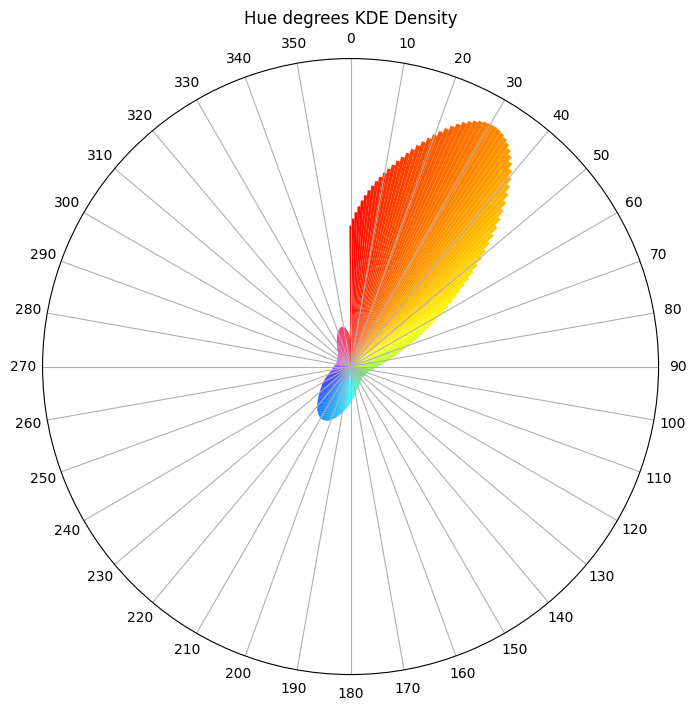

In [28]:
plotter.plot_hues(features[:, 0], features[:, 1], weights=weights)

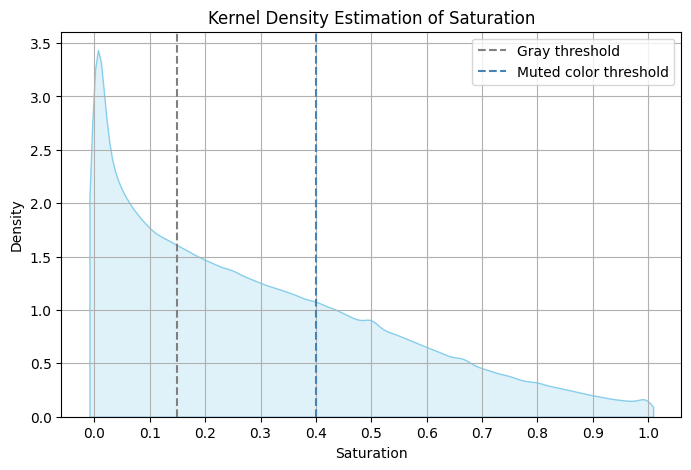

In [29]:
plotter.plot_saturation(features[:, 2], weights=weights)

In [30]:
weights = np.array(weights).astype(float).flatten()

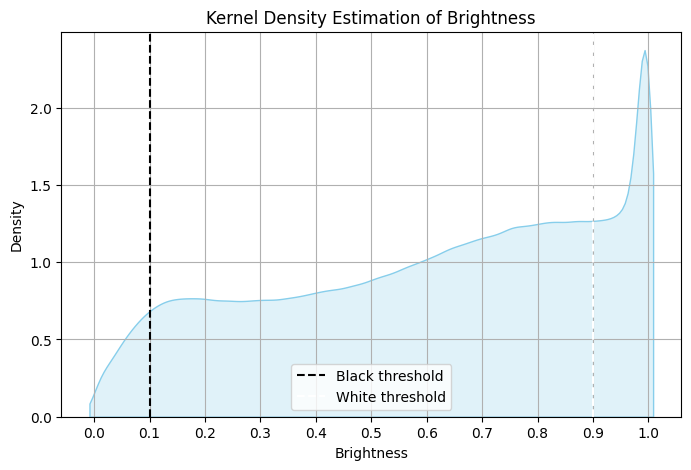

In [31]:
plotter.plot_brightness(features[:, 3], weights=weights)

**2. Clustering**

K = 1000: https://journals.sagepub.com/doi/10.1177/2041669520958431

In [32]:
K = 1000

In [33]:
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)

In [34]:
kmeans.fit(features, sample_weight=weights)

KMeans(n_clusters=1000, n_init=10, random_state=42)

In [35]:
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=["H_sin", "H_cos", "S", "B"])

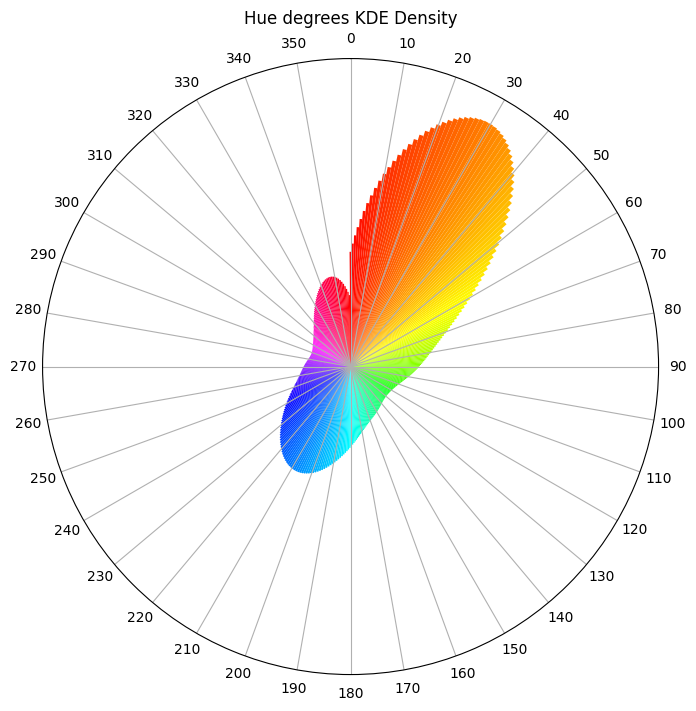

In [36]:
plotter.plot_hues(centroids_df["H_sin"], centroids_df["H_cos"])

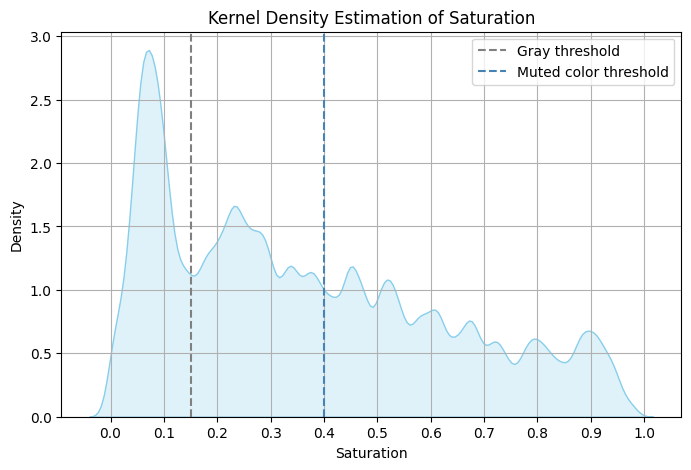

In [37]:
plotter.plot_saturation(centroids_df["S"])

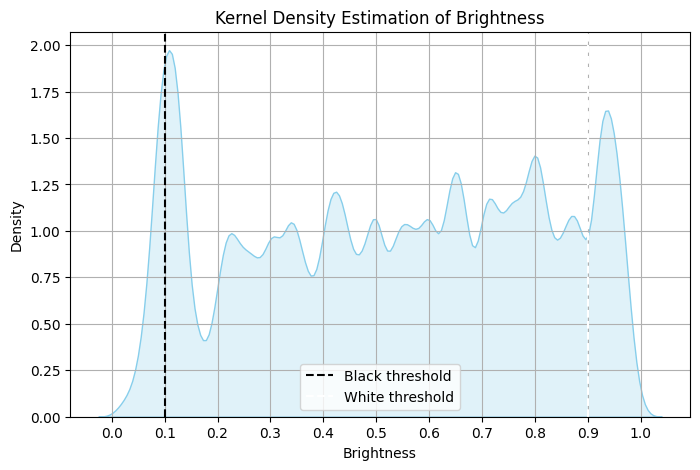

In [38]:
plotter.plot_brightness(centroids_df["B"])

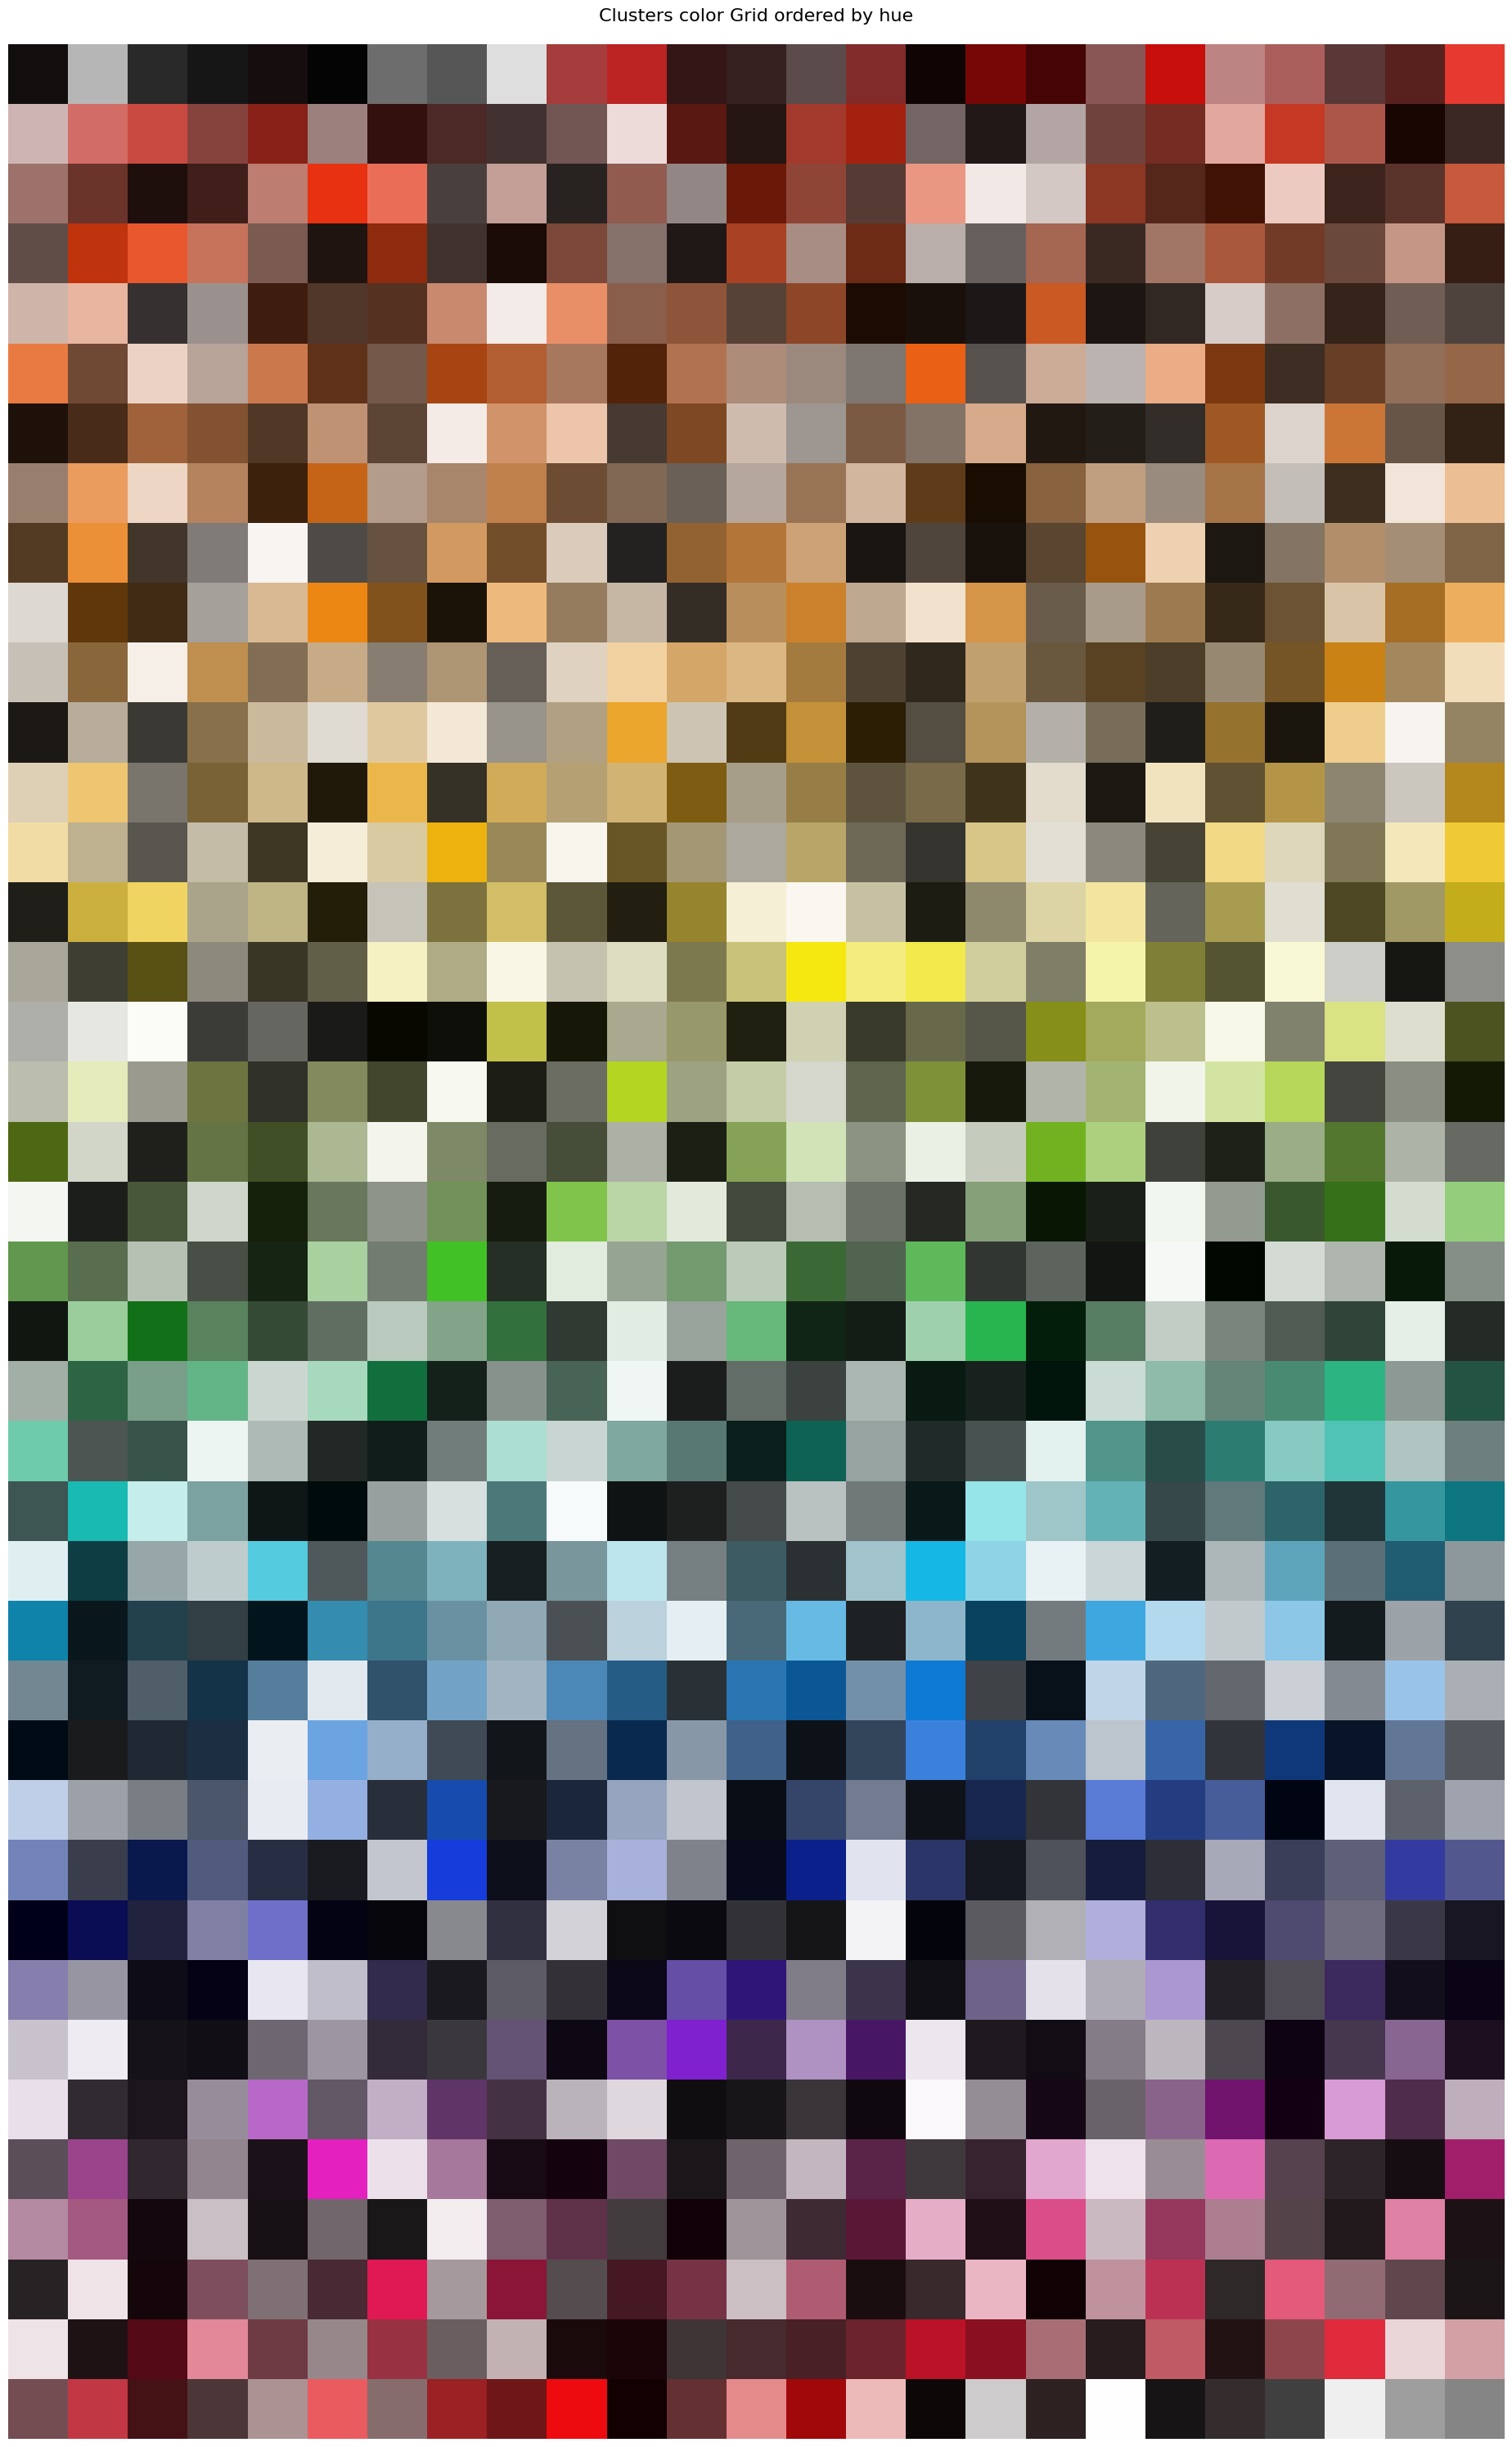

In [8]:
plotter.plot_clusters_color_grid(centroids_df)

**3. Name centroids**

In [39]:
centroids_df["H"] = centroids_df.apply(lambda row: utils.sin_cos_to_hue(row["H_sin"], row["H_cos"]), axis=1)

In [40]:
centroids_df["RGB"] = centroids_df.apply(lambda row: utils.hsb_to_rgb(row["H"], row["S"], row["B"]), axis=1)

In [41]:
centroids_df["HEX"] = centroids_df["RGB"].apply(lambda rgb: '#{:02x}{:02x}{:02x}'.format(*rgb))

In [42]:
# Build KDTree of XKCD colors
xkcd_dict = mcolors.XKCD_COLORS  # names like 'xkcd:vomit yellow'
xkcd_rgb = {
    name[5:]: tuple(int(v * 255) for v in mcolors.to_rgb(hex))  # strip 'xkcd:' and convert
    for name, hex in xkcd_dict.items()
}
xkcd_names = list(xkcd_rgb.keys())
xkcd_rgb_values = list(xkcd_rgb.values())
xkcd_tree = KDTree(xkcd_rgb_values)

In [43]:
# Match each RGB to closest XKCD name
def closest_xkcd(rgb_tuple):
    _, idx = xkcd_tree.query(rgb_tuple)
    return xkcd_names[idx]

In [44]:
centroids_df["name"] = centroids_df["RGB"].apply(closest_xkcd)

In [45]:
centroids_df["name"] = centroids_df["name"].str.replace(' ', '-', regex=False)

In [46]:
centroids_df

,H_sin,H_cos,S,B,H,RGB,HEX,name
0,0.444185,0.895487,0.479501,0.706577,26.382613,"(180, 131, 93)",#b4835d,light-brown
1,-0.530448,-0.846667,0.221075,0.508607,212.067691,"(101, 114, 129)",#657281,battleship-grey
2,0.861548,-0.506465,0.059898,0.563072,120.449305,"(134, 143, 135)",#868f87,grey
3,-0.455428,0.888423,0.240661,0.898369,332.859195,"(229, 173, 198)",#e5adc6,soft-pink
4,0.866025,0.500000,0.026551,0.909424,60.000000,"(231, 231, 225)",#e7e7e1,light-grey
...,...,...,...,...,...,...,...,...
995,-0.780518,-0.623615,0.116296,0.358519,231.375975,"(80, 82, 91)",#50525b,gunmetal
996,0.324111,0.945154,0.819978,0.796316,18.927818,"(203, 89, 36)",#cb5924,copper
997,0.787166,0.616053,0.063512,0.878355,51.952519,"(223, 222, 209)",#dfded1,light-grey
998,0.295973,0.954547,0.078905,0.605370,17.226888,"(154, 145, 142)",#9a918e,grey


In [47]:
centroids_df.to_csv("weighted_color_centroids.csv", index=False)

**4. Transform original colors into color clusters**

In [48]:
new_df = df[["artwork_name", "artist_full_name", "creation_year", "decade", "century", "school", "palette_count", "H", "S", "B"]].copy()

In [49]:
def assign_clusters(row):
    h_rad = np.deg2rad(row["H"])                
    h_sin = np.sin(h_rad)
    h_cos = np.cos(h_rad)
    s = np.array(row["S"])
    b = np.array(row["B"])

    # Create feature array shape (10, 4)
    features = np.stack([h_sin, h_cos, s, b], axis=1)

    # Predict cluster for each color
    return kmeans.predict(features).tolist()

In [50]:
new_df["cluster_labels"] = df.apply(assign_clusters, axis=1)

In [51]:
new_df["cluster_hex"] = new_df["cluster_labels"].apply(
    lambda label_list: [centroids_df.loc[label, "HEX"] for label in label_list]
)

In [52]:
new_df = new_df.drop(columns=["H", "S", "B", "cluster_labels"])

In [53]:
new_df

,artwork_name,artist_full_name,creation_year,decade,century,school,palette_count,cluster_hex
0,70 amx,xynphix,2007.0,2000,21.0,modern,"[4009, 7637, 3303, 6147, 4742, 3908, 7216, 514...","[#f0efef, #9f9e9e, #d16c66, #362020, #edbaba, ..."
1,crucifixion (detail),andrea da firenze,1366.0,1360,14.0,Italy,"[6226, 6056, 4293, 6101, 5185, 5292, 6392, 384...","[#9b807e, #895655, #86423d, #593837, #2e2121, ..."
2,faith,giuseppe angeli,1754.0,1750,18.0,Italy,"[1007, 4537, 4708, 4466, 4432, 2946, 4776, 448...","[#130101, #aa5f5c, #812b2b, #341616, #d2a0a5, ..."
3,lamp post,williamsnape,2010.0,2010,21.0,modern,"[4225, 4308, 4914, 6274, 6911, 6261, 6753, 421...","[#ceb5b4, #866c6d, #593837, #362020, #4c2926, ..."
4,the one that got away,katiehofgard,2009.0,2000,21.0,modern,"[43399, 1136, 407, 2637, 2812, 679, 3585, 2514...","[#fefefe, #fefefe, #fefefe, #aa5f5c, #a63d3d, ..."
...,...,...,...,...,...,...,...,...
264242,truth,circlekeeper,2008.0,2000,21.0,modern,"[1312, 5526, 9605, 9971, 4030, 5524, 5562, 286...","[#aa5f5c, #9b807e, #2e2121, #161414, #362020, ..."
264243,yavanna queen of the earth giver of fruits-tif...,tiffany-illustration,2017.0,2010,21.0,modern,"[15056, 255, 5087, 6846, 9838, 1577, 4027, 476...","[#fefefe, #fefefe, #f0efef, #bc8483, #895655, ..."
264244,unknown,kano furunobu,1700.0,1700,18.0,Japan,"[3431, 5740, 4247, 4971, 6362, 6885, 5328, 445...","[#ab9293, #bc8483, #aa5f5c, #bc8483, #895655, ..."
264245,unknown,wang yuanqi,1715.0,1710,18.0,China,"[6512, 6102, 860, 6846, 4826, 5036, 5117, 3297...","[#f0efef, #f0efef, #edbaba, #edbaba, #fefefe, ..."


In [54]:
new_df.to_csv("weighted_omniart-post-color-clustering.csv", index=False)